In [210]:
# general purpose libraries
import numpy as np
import numpy.linalg as lg
from matplotlib import pyplot as plt

# orthogonal polynomials
from scipy.special import jacobi
from scipy.linalg import solve_banded

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [211]:
def d_dx(f, eps=0.0001):
    return lambda x: (f(x+eps) - f(x))/eps

def d2_dx2(f, eps=0.0001):
    return lambda x: d_dx(d_dx(f, eps), eps)(x)

In [231]:
# Initializing the variables
m1, m2, m3, m4, m5 = 10, 3, 1, 1, 7
k1, k2, k3 = 1, 2, 2
p1, p2, p3 = 4, 1, 1
q1, q2, q3 = 1, 2, 1
alpha1, alpha2 = 1, 1
a, b = -1, 1

u = lambda x: m1*sin(m2*x) + m3*cos(m4*x) + m5
k = lambda x: k1*cos(k2*x) + k3
p = lambda x: p1*sin(p2*x) + p3
q = lambda x: q1*cos(q2*x) + q3

du_dx = lambda x: d_dx(u, 0.0000001)(x)#-m1*m2*sin(m2*x) - m3*m4*sin(m4*x)
d2u_dx2 = lambda x: d2_dx2(u, 0.0000001)(x)#-m2*m2*m2*cos(m2*x) - m3*m4*m4*cos(m4*x)
dk_dx = lambda x: -k1*k2*sin(k2*x)

bound_a = lambda v, dv_dx: -k(a)*dv_dx(a) + alpha1*v(a)
bound_b = lambda v, dv_dx: k(b)*dv_dx(b) + alpha2*v(b)

# differential operator
A = lambda v, dv_dx, d2v_dx2: lambda x: -(dk_dx(x) * dv_dx(x)) - (k(x) * d2v_dx2(x)) + p(x) * dv_dx(x) + q(x) * v(x)
f = lambda x: A(u, du_dx, d2u_dx2)(x)

# boundary values
mu1 = bound_a(u, du_dx)
mu2 = bound_b(u, du_dx)

In [232]:
# defining grid space
n = 10
x, h = np.linspace(a, b, n+1, endpoint=True, retstep=True)

# defining finite differential scheme: c1_i*y_{i+1} + c2_i*y_i + c3_i*y_{i-1} = h^2*f_i
c1 = lambda i: -k(x[i]+h/2) + h*p(x[i])/2
c2 = lambda i: k(x[i]+h/2) + k(x[i]-h/2) + (h**2)*q(x[i])
c3 = lambda i: -k(x[i]-h/2) - h*p(x[i])/2
fi = lambda i: f(x[i])*(h**2)

# boundary conditions:
# -k_0*(y_{0+1} - y_0) + h*alpha1*y_0 = h*mu1
a0 = k(x[0]) + alpha1*h
a1 = -k(x[0])
# k_n*(y_n - y_{n-1}) + h*alpha2*y_n = h*mu2
z0 = -k(x[n])
z1 = k(x[n]) + alpha2*h

# constructing tridiagonal matrix: Ly = c
UDL = np.zeros(shape=(3, n+1))

UDL[1, 0], UDL[1, n] = a0, z1
UDL[0, 1] = a1
UDL[2, n-1] = z0

c = np.ndarray(shape=(n+1))
c[0], c[n] = mu1*h, mu2*h

for i in range(1, n):
    UDL[1, i] = c2(i)
    UDL[0, i+1] = c1(i)
    UDL[2, i-1] = c3(i)
    c[i] = fi(i)
    
y = solve_banded((1, 1), UDL, c)

#L = np.zeros(shape=(n+1, n+1))
#L[0, 0], L[0, 1] = a0, a1
#L[n, n-1], L[n, n] = z0, z1
#for i in range(1, n):
#    L[i, i-1], L[i, i], L[i, i+1] = c3(i), c2(i), c1(i)
#y1 = lg.solve(L, c)

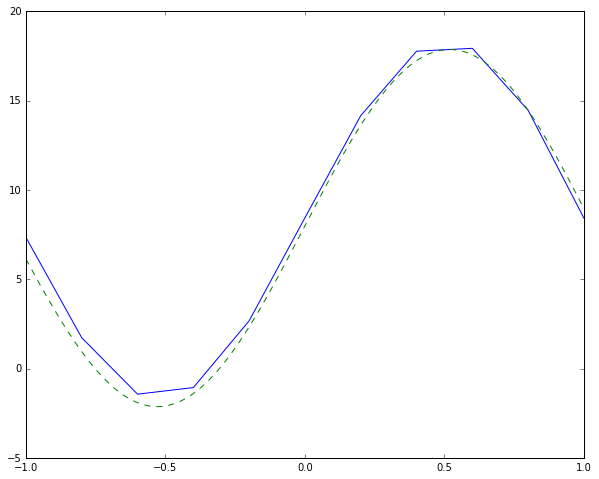

In [233]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')


xplot = np.linspace(a, b, n+1, True)
xpoints = np.linspace(a, b, 1000, True)
ysol = y
yorig = u(xpoints)

plt.plot(xplot, ysol)
plt.plot(xpoints, yorig, '--')

In [234]:
# defining grid space
n = 10
#hstep = (b-a)/n
h = (b-a)/n
x, h = np.linspace(a-h/2, b+h/2, n+2, endpoint=True, retstep=True)
#print(h, hstep)
#assert h == hstep
#h = hstep

# defining finite differential scheme: c1_i*y_{i+1} + c2_i*y_i + c3_i*y_{i-1} = h^2*f_i
c1 = lambda i: -k(x[i]+h/2) + h*p(x[i])/2
c2 = lambda i: k(x[i]+h/2) + k(x[i]-h/2) + (h**2)*q(x[i])
c3 = lambda i: -k(x[i]-h/2) - h*p(x[i])/2
fi = lambda i: f(x[i])*(h**2)

# boundary conditions:
# -k_0*(y_{0+1} - y_0) + h*alpha1*y_0 = h*mu1
a0 = k(a) + alpha1*h/2
a1 = -k(a) + alpha1*h/2
# k_n*(y_n - y_{n-1}) + h*alpha2*y_n = h*mu2
z0 = -k(b) + alpha2*h/2
z1 = k(b) + alpha2*h/2

# constructing tridiagonal matrix: Ly = c
UDL = np.zeros(shape=(3, n+2))

UDL[1, 0], UDL[1, n+1] = a0, z1
UDL[0, 1] = a1
UDL[2, n] = z0

c = np.ndarray(shape=(n+2))

for i in range(1, n+1):
    UDL[1, i] = c2(i)
    UDL[0, i+1] = c1(i)
    UDL[2, i-1] = c3(i)
    c[i] = fi(i)
    
c[0], c[n+1] = mu1*h, mu2*h
y = solve_banded((1, 1), UDL, c)

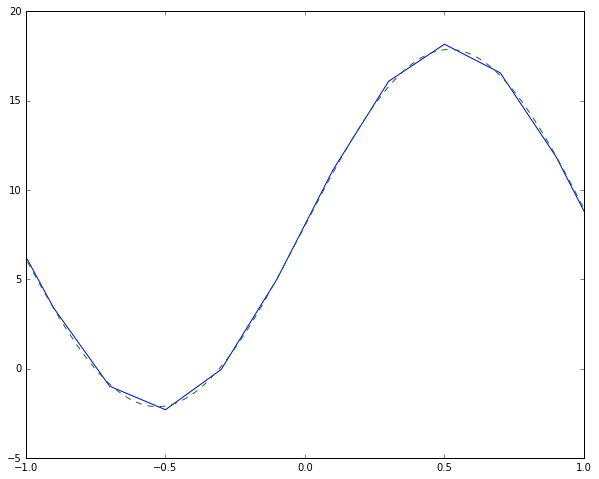

In [235]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')


xplot = np.linspace(a-h/2, b+h/2, n+2, True)
xpoints = np.linspace(a-h/2, b+h/2, 1000, True)
ysol = y
yorig = u(xpoints)
plt.xlim((a,b))
plt.plot(xplot, ysol)
plt.plot(xpoints, yorig, '--')

In [192]:
# defining grid space
n = 30
x, h = np.linspace(a, b, n+1, endpoint=True, retstep=True)

# defining finite differential scheme: c1_i*y_{i+1} + c2_i*y_i + c3_i*y_{i-1} = h^2*f_i
ui = lambda i: k(x[i] - h/2)
di = lambda i: -(k(x[i+1] - h/2) + k(x[i] - h/2) + q(x[i])*(h**2))
ci = lambda i: k(x[i+1] - h/2)
bi = lambda i: -f(x[i])*(h**2)

# boundary conditions:
# -k_0*(y_{0+1} - y_0) + h*alpha1*y_0 = h*mu1
d0 = alpha1 + q(x[0])*h/2 + k(x[1] - h/2)/h
c0 = -k(x[1] - h/2)/h
b0 = mu1 + f(x[0])*h/2

un = -k(x[n] - h/2)/h
dn = alpha2 + q(x[n])*h/2 + k(x[n] - h/2)/h
bn = mu2 + f(x[n])*h/2

# constructing tridiagonal matrix: Ly = c
UDL = np.zeros(shape=(3, n+1))

UDL[1, 0], UDL[1, n] = d0, dn
UDL[0, 1] = c0
UDL[2, n-1] = un

c = np.ndarray(shape=(n+1))
c[0], c[n] = b0, bn

for i in range(1, n):
    UDL[1, i] = di(i)
    UDL[0, i+1] = ci(i)
    UDL[2, i-1] = ui(i)
    c[i] = bi(i)
    
y = solve_banded((1, 1), UDL, c)

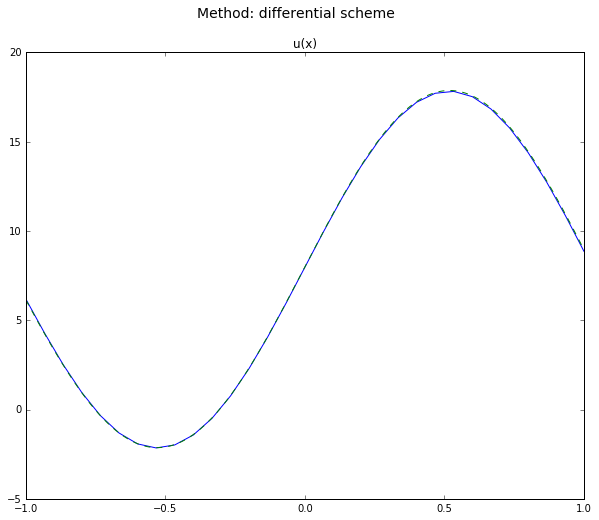

In [193]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.suptitle('Method: differential scheme', size=14)

xplot = np.linspace(a, b, n+1, True)
xpoints = np.linspace(a, b, 1000, True)
ysol = y
yorig = u(xpoints)

plt.title('u(x)')
plt.plot(xplot, ysol)
plt.plot(xpoints, yorig, '--')